[Open in colab](https://colab.research.google.com/drive/1TG_z6ZpCP9ai6OpOnWg4217FjpwkgiO3)

# Is it possible to make clustering naturally from encoding?
An idea that is works similarly to [self-organizing map](https://en.wikipedia.org/wiki/Self-organizing_map) (SOM) only with distributed representation.

Layer X of size $N$ encodes the input with $a_x=const$ active neurons. Inputs are not random, but comes from several clusters. 
Layer Y of size $M$ receives an activation from X via weights $w$ with $a_w=const$ number of ones.

$y = wx > k$ where $k$ is a threshold. Learning rule is rearangement of weights with some probability. I will use cosyne similarity and Hamming distance. 



* How to encode real valued 2d data  on input X to the sparse distributed rpresentation?
* How the density of inputs in a one cluster influence encoding. How encoding represen $p(x)$?
*   List item




## Solution Attempt 1 (ViOs)


## Python experiments

Lets generate the dataset from two 2d gausians. Then I will convert it int.

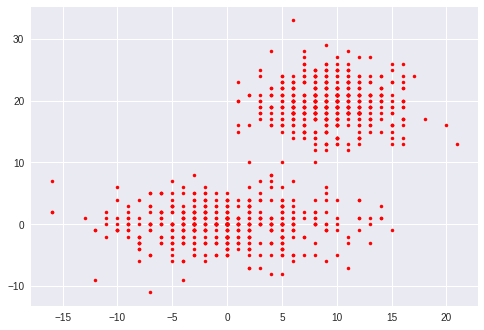

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# the data will be two dimensional drawn from gausians

mean1 = (1, 2)
cov1 = [[.1, 0], [0, .1]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 500).T

mean2 = (0, 0)
cov2 = [[0.3, 0], [0, .1]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 500).T

x, y = np.append(x1,x2), np.append(y1, y2)

x = (x * 10).astype(int)
y = (y * 10).astype(int)
# plt.plot(x1, y1, 'b.')
# plt.plot(x2, y2, 'r.')

plt.plot(x, y, 'r.')
plt.show()



def generate_vector(N, a):
    assert N >= a, 'number of active neurons should be smaller'
    ind = np.random.choice(N, size=a, replace=False)
    vector = np.zeros(N, dtype='uint8')
    vector[ind] = 1
    return vector
  
def generate_matrix((M, N), a):
    assert N >= a, 'number of active neurons in a row should be smaller'
    vector = []
    for i in range(M):
        vector.append(generate_vector(N, a))
    vector = np.array(vector)
    return vector

I will assume that the network sees dots one at a time, randomly, sequentially.  (Another strategy to test later: the network sees all the dots at once, or group of dots). Single dot I will encode through linear weighted sum. It uses the ideas from coarse coding.

In [0]:
# size of the layers
N=50
M=200
# sparsity of activation
s_x = 0.8
s_w = 0.2

a_x = int(s_x * N)
a_w = int(s_w * N)

k_max = int(min([a_x, a_w]))


x = generate_vector(N, a_x)
w = generate_matrix((N, M), a_w)
k_slide = 3

def get_stat_for_network(iters=100):
    Y = np.zeros((iters, k_max + k_slide))
    for i in range(iters):
        x = generate_vector(N, a_x)
        w = generate_matrix((M, N), a_w)
        Y[i] = np.bincount(np.dot(w, x).astype(int), minlength=k_max + k_slide)

    return np.mean(Y, axis=0)

p_exp = (get_stat_for_network(100)).astype(int)
print(p_exp)

[ 0  0  0  0  0  3 15 43 68 53 16  0  0]


p_exp is not a true probability distribution but multiplied by M. It help to understand the meaning, the avarage number of neurons that have particular activation.  If you noted the solution does not depend on number of neurons in Y layer, but we still use it. Since the neurons are independent and have different weights we can use an ergodic principle (you could run experiments for one neuron many times, or one time for many neurons). But we still added iterations to average result and make it more stable.

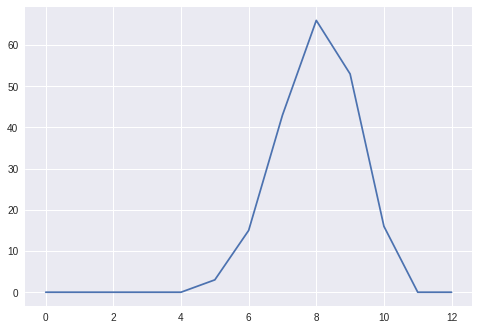

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(k_max + k_slide), (get_stat_for_network(100)).astype(int))
plt.show()

Compare it with the theory

[1.94698777e-08 7.78795109e-06 6.83392708e-04 2.30834870e-02
 3.73663946e-01 3.22845650e+00 1.56938858e+01 4.35585400e+01
 6.73796166e+01 5.32382156e+01 1.65038468e+01]


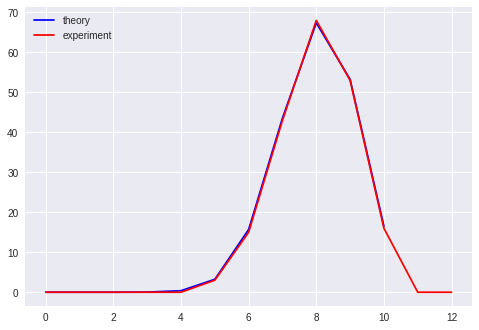

In [0]:
from decimal import Decimal
import math

def C(b, s):
    # number of combinations
    if s == 0 or s == b:
        return 1
    return reduce(lambda x, y: x*y, range(b-s+1,b+1))/math.factorial(s)

  
k_slide = 1  
  
def prob_distr(N, a_x, a_w):
    k_max = min(a_x, a_w)
    p = np.zeros(k_max + k_slide)
    for k in range(k_max + k_slide):
        p[k] = Decimal(C(a_x, k)) * C(N - a_x, a_w - k) / C(N, a_w)
    return p
  
p_theory = prob_distr(N, a_x, a_w)
print(p_theory * M) 

plt.plot(range(p_theory.size), p_theory * M,  'b' , label='theory',)
plt.plot(range(p_exp.size), p_exp, 'r', label='experiment')
plt.legend(loc='upper left')
plt.show()

Result is satisfying.

## Intuition

You can see that some neurons are very active some are not, and the average somewhere in the middle. Depending on the parameters the curve will shift from left (weakly active) to the right (over active).  The lesson from this simple task is that it is not straightforward to chose the threshold function to make a binary responce in Y layer. This is the basic task wich is used to solve more complex, with negative connections or activation, with lateral inibition or with real valued parameters.